# Reddit Flair Classification

## **Data Analysis and Baseline Models**

This notebook demonstrates simple data exploration and building baseline models using different features and algorithms. Since our dataset is almost balenced, we will use the metric accuracy to evaluate the results.

In [0]:
import csv
import os
import random
import json
import numpy as np
import pandas as pd
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
import gc
import seaborn as sns
color = sns.color_palette()

eng_stopwords = set(stopwords.words("english"))

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import re, string
from sklearn.metrics import log_loss
%matplotlib inline

print('Python version:',np.version)
print('Pandas version:',pd.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Python version: <module 'numpy.version' from '/usr/local/lib/python3.6/dist-packages/numpy/version.py'>
Pandas version: 0.22.0


### Loading the train and test sets and displaying number of samples for each flair category

In [0]:
train_json = []

for line in (open('train.json', 'r')):
    train_json.append(json.loads(line))

train = pd.DataFrame.from_records(train_json)

flairs = list(set(train['link_flair_text']))
for flair in flairs:
    print (flair,': ' , len(train[train['link_flair_text'] == flair]))

Photography :  554
Science/Technology :  1626
Sports :  1719
Scheduled :  1596
Food :  1656
[R]eddiquette :  1604
Policy/Economy :  1431
Business/Finance :  1604
Politics :  1587
Non-Political :  1586
AskIndia :  1523


In [0]:
test_json = []

for line in (open('test.json', 'r')):
    test_json.append(json.loads(line))

test = pd.DataFrame.from_records(test_json)

flairs = list(set(test['link_flair_text']))
for flair in flairs:
    print (flair,': ' , len(test[test['link_flair_text'] == flair]))

Photography :  86
Science/Technology :  374
Sports :  281
Scheduled :  372
Food :  344
[R]eddiquette :  396
Policy/Economy :  569
Business/Finance :  396
Politics :  413
Non-Political :  414
AskIndia :  477


### Lets observe the different features we have:
```
1. author - Author name
2. comments - list of top comments (limited to 10)
3. created_utc - timestamp of creation of post
4. link_flair_text - flair of the post
5. num_comments - number of comments
6. over_18 - described as whether post is age restricted or not
7. score - calculated as upvotes - downvotes
8. selftext - body of the post
9. title - title of the post
10. url - url associated with the post
```

In [0]:
train.head(1)

,_id,author,comments,created_utc,id,link_flair_text,num_comments,over_18,score,selftext,title,url
0,{'$oid': '5c5959797cf03b047caaa61a'},[deleted],"[Listen to me. \n\n5 years down the line, this...",1524926782,8fkbkh,[R]eddiquette,29,False,50,"So, I didn't do well in JEE Mains, even after ...",[R] Losing the will to live every single day,https://www.reddit.com/r/india/comments/8fkbkh...


Creating a mapping from labels to ids and vice-versa

In [0]:
label_to_id = {'AskIndia': 0,
 'Business/Finance': 1,
 'Food': 2,
 'Non-Political': 3,
 'Photography': 4,
 'Policy/Economy': 5,
 'Politics': 6,
 'Scheduled': 7,
 'Science/Technology': 8,
 'Sports': 9,
 '[R]eddiquette': 10}

id_to_label = {v: k for k, v in label_to_id.items()}
id_to_label

{0: 'AskIndia',
 1: 'Business/Finance',
 2: 'Food',
 3: 'Non-Political',
 4: 'Photography',
 5: 'Policy/Economy',
 6: 'Politics',
 7: 'Scheduled',
 8: 'Science/Technology',
 9: 'Sports',
 10: '[R]eddiquette'}

Since title and body of the post describe the same thing we merge as one. Before that we check if selftext is empty or not.

In [0]:
train['selftext'] = train['selftext'].astype(str)
test['selftext'] = test['selftext'].astype(str)

empties = ['nan', '[deleted]', '[removed]']
for empty in empties:
  print(empty, len(train[train['selftext'] == empty]))

nan 10262
[deleted] 2428
[removed] 926


Here we replace removed, nan or deleted text in selftext with an empty character

In [0]:
train['selftext'] = train['selftext'].apply(lambda x: '' if x in empties else x)
test['selftext'] = test['selftext'].apply(lambda x: '' if x in empties else x)

In [0]:
empties = ['nan', '[deleted]', '[removed]']
for empty in empties:
  print(empty, len(train[train['selftext'] == empty]))

nan 0
[deleted] 0
[removed] 0


In [0]:
train['title'] = train['title'] + ' ' + train['selftext']
test['title'] = test['title'] + ' ' + test['selftext']

**Before performing any modelling, lets preprocess and clean the text data**

In [0]:
import unicodedata
import re

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
train['title'] = train['title'].apply(lambda x: normalizeString(x))
test['title'] = test['title'].apply(lambda x: normalizeString(x))

### We remove the following features since these do not carry necessary information.

In [0]:
train = train.drop(['_id', 'id', 'url', 'created_utc', 'author', 'selftext'], axis=1)
test = test.drop(['_id', 'id', 'url', 'created_utc', 'author', 'selftext'], axis=1)

A histogram of the sample count per flair

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


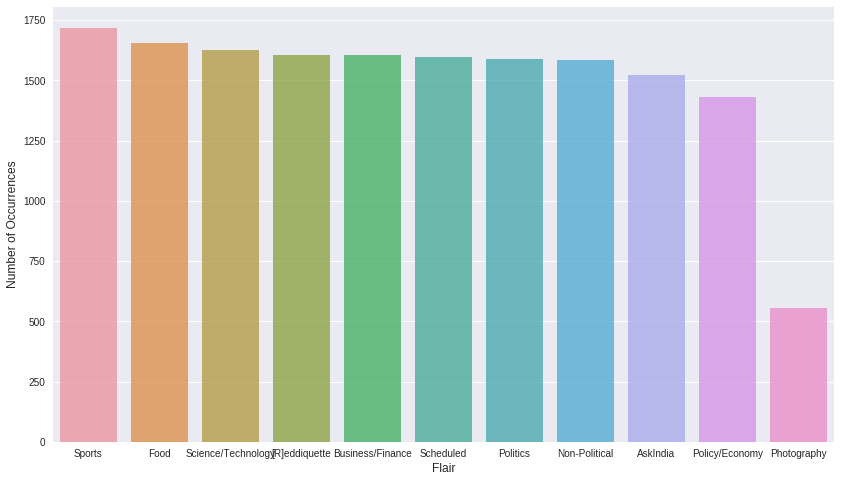

In [0]:
cnt_srs = train['link_flair_text'].value_counts()

plt.figure(figsize=(14,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Flair', fontsize=12)
plt.show()

### Meta Features:

### Let us build some  creating meta featues and see how good are they at predicting the flairs. The feature list is as follows:

1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords
5. Number of punctuations
6. Number of upper case words
7. Number of title case words
8. Average length of the words
9. Converting over_18 to binary
10. Converting num_comments and score to float

In [0]:
train["over_18"] = train["over_18"].apply(lambda x: 1 if x == True else 0)
test["over_18"] = test["over_18"].apply(lambda x: 1 if x == True else 0)

train["num_comments"] = train["num_comments"].apply(lambda x: float(x))
test["num_comments"] = test["num_comments"].apply(lambda x: float(x))

train["score"] = train["score"].apply(lambda x: float(x))
test["score"] = test["score"].apply(lambda x: float(x))

train["num_words"] = train["title"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["title"].apply(lambda x: len(str(x).split()))

train["num_unique_words"] = train["title"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["title"].apply(lambda x: len(set(str(x).split())))

train["num_chars"] = train["title"].apply(lambda x: len(str(x)))
test["num_chars"] = test["title"].apply(lambda x: len(str(x)))

train["num_stopwords"] = train["title"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test["num_stopwords"] = test["title"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

train["num_punctuations"] =train['title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

train["num_words_upper"] = train["title"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["title"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

train["num_words_title"] = train["title"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["title"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

train["mean_word_len"] = train["title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))



**Preparing to build a classifier on the meta features to see if they help in predicting**

In [0]:
train_y = train['link_flair_text'].map(label_to_id)
test_y = test['link_flair_text'].map(label_to_id)

train["num_words"] = train["title"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["title"].apply(lambda x: len(str(x).split()))
train["mean_word_len"] = train["title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['comments' ,'title']
train_X = train.drop(cols_to_drop+['link_flair_text'], axis=1)
test_X = test.drop(cols_to_drop+['link_flair_text'], axis=1)

**Lets train a simple XGBoost with only the meta features**

In [0]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=500):
    param = {}
    param['objective'] = 'multi:softmax'
    param['eta'] = 0.12
    param['max_depth'] = 5
    param['silent'] = 1
    param['num_class'] = 11
    param['eval_metric'] = 'mlogloss'
    param['min_child_weight'] = 1
    param['subsample'] = 0.5
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return model

**Run the XGBoost model**

In [0]:
import pickle

model = runXGB(train_X, train_y, test_X, test_y)
name = "meta.pickle" + str(0) + ".dat"
pickle.dump(model, open(name, "wb"))

[0]	train-mlogloss:2.34311	test-mlogloss:2.34465
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:2.30251	test-mlogloss:2.30598
[2]	train-mlogloss:2.2676	test-mlogloss:2.27166
[3]	train-mlogloss:2.2377	test-mlogloss:2.23433
[4]	train-mlogloss:2.20959	test-mlogloss:2.19981
[5]	train-mlogloss:2.18532	test-mlogloss:2.1709
[6]	train-mlogloss:2.16255	test-mlogloss:2.14441
[7]	train-mlogloss:2.14236	test-mlogloss:2.12139
[8]	train-mlogloss:2.12472	test-mlogloss:2.10423
[9]	train-mlogloss:2.10848	test-mlogloss:2.08745
[10]	train-mlogloss:2.09474	test-mlogloss:2.07595
[11]	train-mlogloss:2.08077	test-mlogloss:2.0612
[12]	train-mlogloss:2.067	test-mlogloss:2.05002
[13]	train-mlogloss:2.05461	test-mlogloss:2.03927
[14]	train-mlogloss:2.04264	test-mlogloss:2.02591
[15]	train-mlogloss:2.03132	test-mlogloss:2.01612
[16]	train-mlogloss:2.02122	test-mlogloss:2.00902
[17]	train-mlog

**Lets observe which of the features are important**

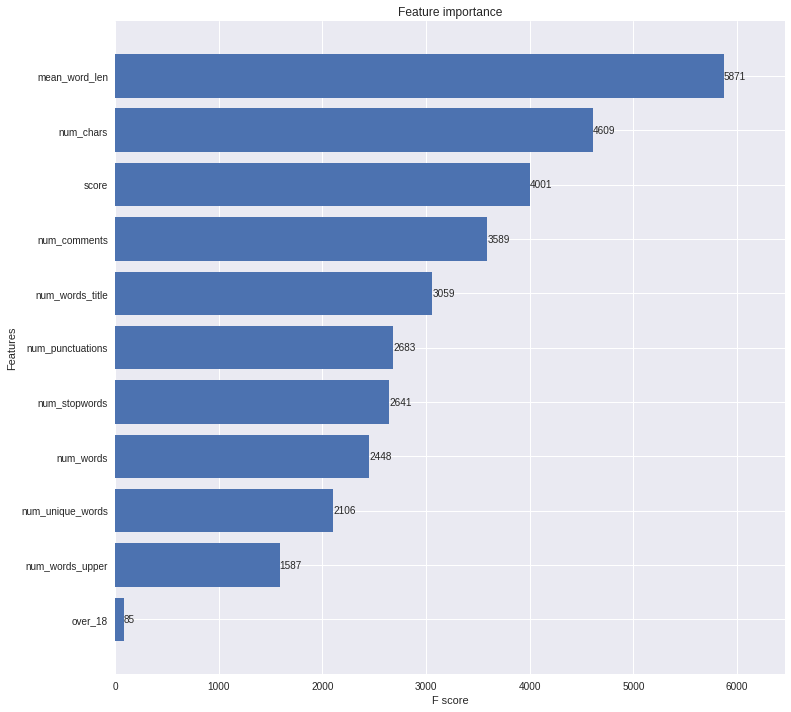

In [0]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

**Perform predictions on test set and evaluate accuracy**

In [0]:
def accuracy(out, labels):
  count = 0
  for i,j in zip(out,labels):
    if i == j:
      count += 1
  return (count/len(labels)) * 100

### Run evaluation on dev set

In [0]:
preds = []
preds[:] = model.predict(xgb.DMatrix(test_X))
new_preds = []
for i in preds:
  new_preds.append(int(i))

print ('Accuracy on test set using meta features', accuracy(new_preds, test_y), '%')

Accuracy on test set using meta features 32.58127122755944 %


**Displaying the confusion matrix**

In [0]:
nb_classes = 11

confusion_matrix = np.zeros((nb_classes, nb_classes))
for t, p in zip(test_y, new_preds):
  confusion_matrix[t, p] += 1
      
confusion_matrix = np.flip(confusion_matrix, 0)

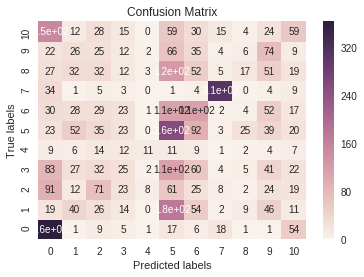

In [0]:
    
l = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, ax = ax, ); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(l); ax.yaxis.set_ticklabels(l);

**Building a TFIDF vectorizer on title feature **

In [0]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train['title'].values.tolist() + test['title'].values.tolist())
train_tfidf = tfidf_vec.transform(train['title'].values.tolist())
test_tfidf = tfidf_vec.transform(test['title'].values.tolist())

**Helper Function to train using different algorithms**

In [0]:
from sklearn.metrics import accuracy_score
import time

def train_predict(learner, X_train, y_train, X_test, y_test): 
    
    results = {}
    
    start = time.time() 
    learner = learner.fit(X_train, y_train)
    end = time.time() 
    
    results['train_time'] = end - start
    
    start = time.time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time.time()
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    results['acc_test'] = accuracy_score(y_test, predictions_test)
       
    print ("{} trained.".format(learner.__class__.__name__))
        
    return results

**Running 3 different baseline on test set**

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

clf_A = MultinomialNB()
clf_B = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
clf_C = LogisticRegression(n_jobs=1, C=1e5)

results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name][i] = train_predict(clf, train_tfidf, train_y, test_tfidf, test_y)

MultinomialNB trained.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier trained.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression trained.


**Results for the baseline**

In [0]:
for i, result in results.items():
  for j, res in result.items():
    print (i, ' Results')
    print ('Test Accuracy', res['acc_test'], 'Test F1 Score', res['f_test'], '\n')

MultinomialNB  Results
Test Accuracy 0.5477923338185346 Test F1 Score 0.5477923338185346 

SGDClassifier  Results
Test Accuracy 0.5630761766132946 Test F1 Score 0.5630761766132946 

LogisticRegression  Results
Test Accuracy 0.5545851528384279 Test F1 Score 0.5545851528384279 

